In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def calc_gamma(l):
    """
    Calcula a aceleração da gravidade no elipsóide de referência (WGS 84) pela equação de Somigliana
    """
    
    a = 6378137.0
    b = 6356752.3142
    ga = 9.7803253359
    gb = 9.8321849378
    
    numerador = a * ga * np.cos(np.pi*l/180)**2 + b*gb*np.sin(np.pi*l/180)**2
    denominador = np.sqrt(a**2 * (np.cos(np.pi*l/180)**2) + b**2*(np.sin(np.pi*l/180)**2))
    
    return numerador/denominador


def plota_gamma(l, gamma):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(l, gamma)
    ax.set_xlabel('Latitude (º)', fontsize=14)
    ax.set_ylabel('g (m/s$^2$)', fontsize=14)
    ax.set_title('Aceleração da gravidade calculada pela fórmula de Somigliana', fontsize=14)
    ax.set_xlim([-90, 90])
    ax.set_ylim([9.75, 9.85])
    ax.grid()
    plt.show()
    
    
def seleciona_area(data, area):
    
    """
    Seleciona uma área no arquivo de dados a partir das coordenadas fornecidas. Foi feito asism
    para ser mais rápido do que plotar o arquivo todo e só depois selecionar a área.
    """

    if area[2] < 0:
        area[2] = 360 + area[2]
    if area[3] < 0:
        area[3] = 360 + area[3]

    d_lat = np.unique(data[:,1])[1] - np.unique(data[:,1])[0]
    d_lon = data[1, 0] - data[0, 0]
    
    # seleciona latitudes
    lat_ind1 = np.abs(data[:,1]-area[0]).argmin()
    lat_ind2 = np.abs(data[:,1]-area[1] + d_lat).argmin()
    data2 = data[lat_ind1:lat_ind2, :]

    # seleciona longitudes
    lon_inds = np.where((data2[:,0] > area[2]) & (data2[:,0] < (area[3] + d_lon)))
    data3 = data2[lon_inds[0], :]
   
    out_data = reorganiza(data3, area)

    return out_data


def reorganiza(d, area):
    
    d_lat = np.unique(d[:,1])[1] - np.unique(d[:,1])[0]
    d_lon = d[1, 0] - d[0, 0]
    
    if np.shape(d)[1]==4:
        lon, lat, alt, g = d[:,0], d[:,1], d[:,2], d[:,3]
        lon2 = lon[:int(np.abs(area[3]-area[2])/d_lon)]
        lat2 = np.reshape(lat, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])[:, 1]  # acho que não precisa desse indice
        alt2 = np.reshape(alt, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])
        g2 = np.reshape(g, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])

        return [lon2, lat2, alt2, g2]
    
    if np.shape(d)[1]==3:
        lon, lat, topog = d[:,0], d[:,1], d[:,2]
        lon2 = lon[:int(np.abs(area[3]-area[2])/d_lon)]
        lat2 = np.reshape(lat, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])[:, 1]  # acho que não precisa desse indice
        topog2 = np.reshape(topog, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])

        return [lon2, lat2, topog2]


def plota_mapa(xx, yy, zz, title=None, escala=None):

    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    z = plt.contourf(xx, yy, zz, 120, transform=ccrs.PlateCarree(), cmap='RdBu_r')
    
    if escala:
        plt.colorbar(z, ax=ax, label=escala, shrink=0.5)

    ax.coastlines(resolution='50m')
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    
    if title:
        ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

### calcular a aceleração pela formula de Somigliana

In [3]:
dados = np.loadtxt('eigen-6c3stat-0_5-mundo.txt')
lat = np.unique(dados[:,1])
somig = calc_gamma(lat)

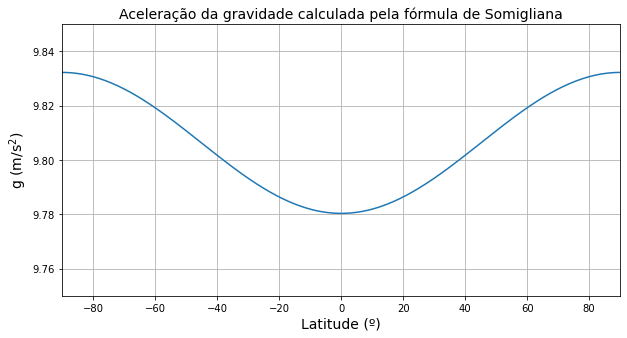

In [4]:
plota_gamma(lat, somig)

**Explique o gráfico acima.** Quais fatores contribuem para este comportamento?

# Mapa de Topografia

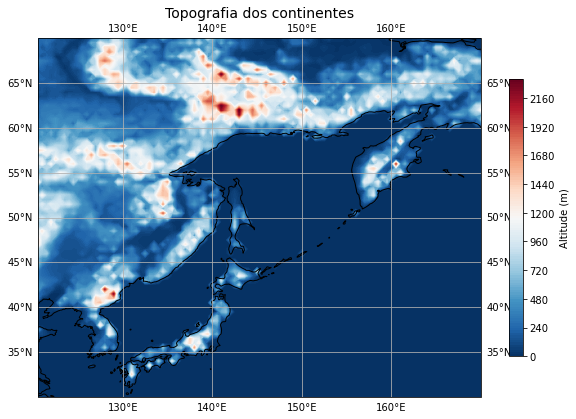

In [5]:
#regiao = [15.0, -60.0, -90.0, -30.0]      # [lat_min, lat_max, lon_min, lon_max]    América do Sul
#regiao = [-10.0, -30.0, -80.0, -60.0]    # [lat_min, lat_max, lon_min, lon_max]    América do Sul (zoom nos Andes)
#regiao = [60.0, 00.0, 50.0, 120.0]       # [lat_min, lat_max, lon_min, lon_max]    Himalaia
#regiao = [60.0, -60.0, -60.0, -5.0]       # [lat_min, lat_max, lon_min, lon_max]    dorsal
regiao = [70, 10, 120, 170]

lon, lat, h, g_medido = seleciona_area(dados, regiao)
plota_mapa(lon, lat, h, title='Topografia dos continentes', escala='Altitude (m)')

# Anomalia Ar-livre

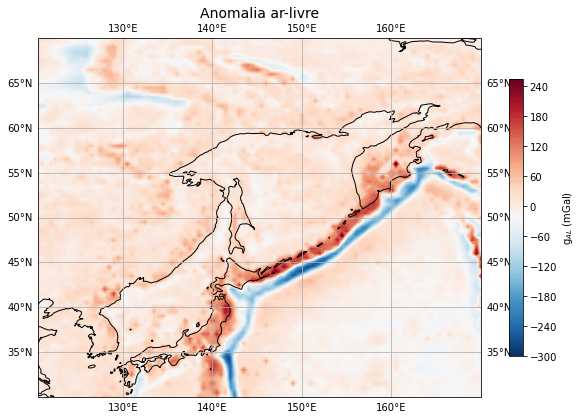

In [6]:
gamma = np.repeat(calc_gamma(lat)*1e5, np.shape(g_medido)[1])
gamma = np.reshape(gamma, np.shape(g_medido))
g_al = g_medido - gamma + 0.3086 * h
plota_mapa(lon, lat, g_al, title='Anomalia ar-livre', escala='g$_{AL}$ (mGal)')

**Faça** uma estimativa do perfil passando pelo paralelo -20º e entre os meridianos -80º e -60º. Explique este comportamento.

# Anomalia Bouger

In [7]:
topog = np.loadtxt('etopo1-0_5-mundo.txt')

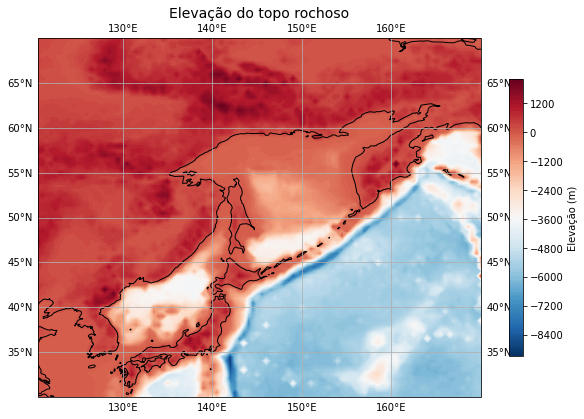

In [8]:
lon, lat, elev = seleciona_area(topog, regiao)
plota_mapa(lon, lat, elev, title='Elevação do topo rochoso', escala='Elevação (m)')

In [9]:
G = 6.67408e-11      # m^3 kg^-1 s^-2
rho_r = 2670         # kg m^3
rho_w = 1040         # kg m^3

b_pos = np.zeros(np.shape(elev))
b_neg = np.zeros(np.shape(elev))

b_pos[elev>=0] = 2 * np.pi * G * rho_r * elev[elev>=0]
b_neg[elev<0] = 2 * np.pi * G * (rho_w - rho_w) * elev[elev<0]
corr_b = (b_pos + b_neg)     # m/s^2

g_b = g_al - (corr_b*1e5)    # mGal

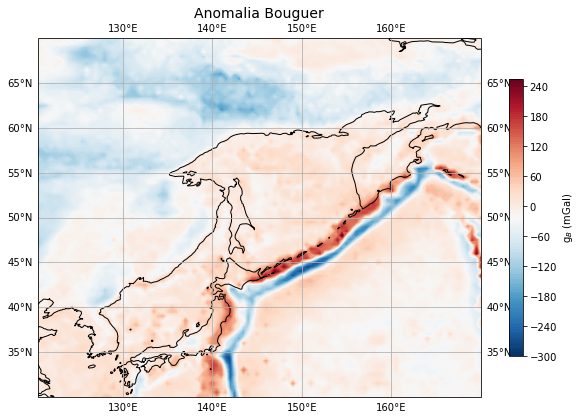

In [10]:
plota_mapa(lon, lat, g_b, title='Anomalia Bouguer', escala='g$_B$ (mGal)')